<a href="https://colab.research.google.com/github/viriditass/Papers/blob/main/Progressive_Growing_of_GANs_for_Improved_Quality%2C_Stability%2C_and_Variation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Progressive Growing of GANs for Improved Quality, Stability, and Variation**

논문 링크: https://arxiv.org/abs/1710.10196

본 논문은 NVIDIA에서 나온 논문으로 progressive growing 즉, 점진적 성장이라는 독특한 아이디어로 훈련 속도와 안정화를 동시에 잡아내어 큰 주목을 받았다. PGAN또는 PGGAN, ProgressiveGAN 등 여러 이름으로 불린다.

일반적인 GAN으로 super-resolution을 진행하는데 여러 문제들이 있다. 먼저 첫번째로 high resolution 일수록 discriminator는 generator가 생성한 image가 fake인지 real인지를 구분하기 쉬워진다. 두번째로 아무리 high-resolution image를 잘 만든다고 하여도 메모리 제약때문에 mini-batch size를 줄여야 하는데, batch size를 줄이게 되면 train이 불안정해지는 현상이 발생한다.

## **PGGAN**

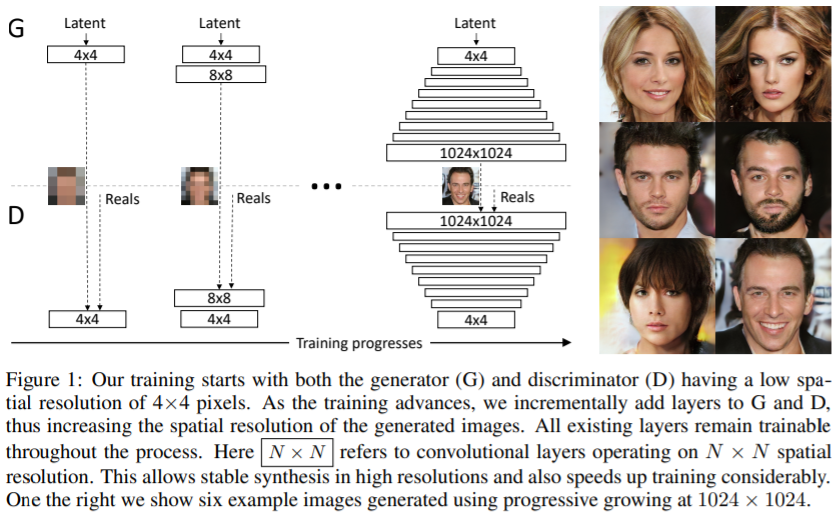

따라서 위와 같은 이유때문에 super-resolution을 진행하기 어려웠는데, 해당 논문에서는 위의 그림 Figure 1과 같이 generator와 discriminator가 마치 거울과 같이 존재한다. 처음에는 4 x 4의 row-resolution output으로 대략적인 윤각을 학습하며, 그 뒤로는 8 x 8, 16 x 16....으로 가로세로가 2배씩 증가하는 것을 알 수 있다. 즉, **low-resolution의 image로부터 시작하여 layer를 점점 쌓아가며 점차 high-resolution으로 만든다**.

그러면 대체 이렇게 점진적으로 layer를 쌓는 것이 무슨 장점이 있는 것일까?

바로 image distribution에서 large scale 구조를 먼저 파악할 수 있도록 도움을 준다. 즉, 초반에 **low-resolution image에서만 볼 수 있는 feature인 large scale structure**들을 보면서 image의 전반적인 내용들을 학습하며, **layer가 쌓일수록 점차 눈, 코, 입 등의 세부적인 finer scale detail**들을 학습한다. 개인적인 생각으로 일러스트레이터같은 분들이 먼저 선을 따고 그림을 그리는 것과 비슷한 느낌인거 같다.

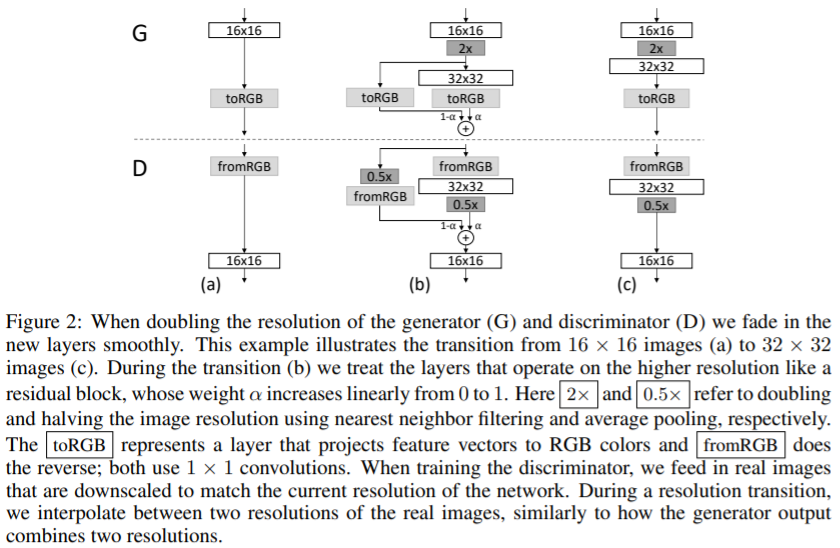

구체적인 network에 새로운 layer를 집어넣는 과정은 어떻게 될까?

위의 그림 Figure 2는 (a) => (c)로 변화하는 과정에 대해 나와있다. 먼저 (a)와 같이 16 x 16의 RGB image를 생성했다고 가정하겠다. 그 다음 바로 32 x 32 image를 학습시킬 수 있다면 좋겠지만, 바로 학습을 진행할시 학습이 하나도 안된 32 x 32 layer의 간섭으로 인하여 기껏 잘 학습이 된 16 x 16 layer에까지 악영향이 갈 수 있다.

따라서 layer를 smooth하게, fade in하게 끼워넣는 방법이 필요하다. 본 논문에서는 이전 layer의 output을 2배로 늘린다. 즉, row-resolution image의 scale만 늘려서 대략적인 형태를 지닌 image를 만들어내는 것이다. 그리고 32 x 32로 만들어진 image와 잘 학습이 된 row-resolution image와 합친다.

이때 그냥 단순히 합치는 것이 아닌, 0~1 사이의 비율을 나타내는 a를 곱하고, row-solution pixel에는 그 나머지 비율인 1-a를 곱하여 서로 더해준다. discriminator 역시 이와 같은 방식으로 진행이 된다. (a의 경우 0에서 1로 점차 증가하는데, 이는 즉, 전 layer의 영향력을 점점 줄이는 것이다.)

그리고 학습이 일정 수준 이상이되면, 이전 layer의 보조를 빼고 그대로 동작시키며 fine-tuning을 진행한다. (이러한 학습을 위해 **WGAN-GP loss를 사용**했다.)

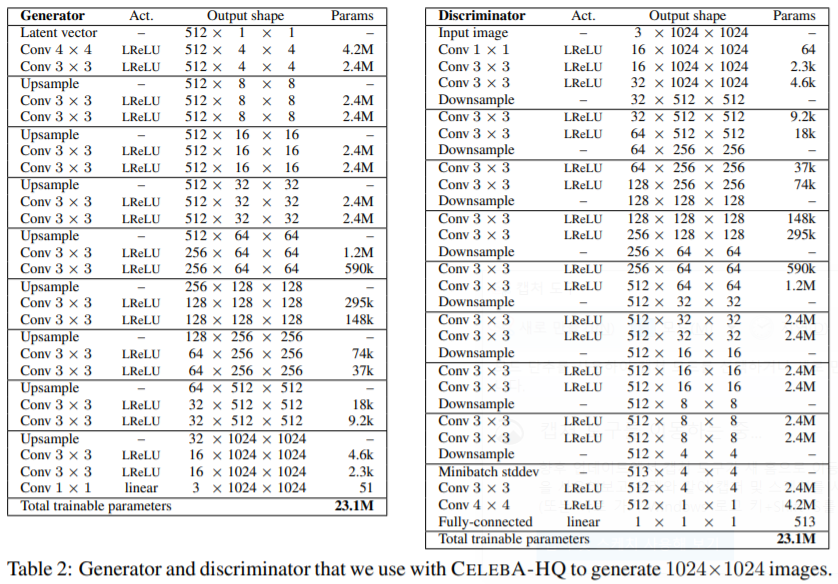

CelebA dataset에 대한 PGGAN의 구조는 위의 표 Table 2와 같다.

### **Increasing Variation Using MiniBatch Standard Deviation**

일반적인 GAN의 특징인 train중 train data로부터 찾은 feature imformation보다 less variation(변화가 적은)한 image를 생성하려는 경향이 있다. 이로 인해 위에서 언급했듯이 high-resolution image를 생성하기 어렵다는 것인데, 본 논문에서는 이를 해결하고자 **minibatch standard deviation**을 제안하게 되었다.

### **Pixelwise Feature Vector Normalization**

GAN 분야에서는 SNGAN 등 기존 CNN 계열에서 많이 사용이되는 batch normalization이 별로 효과가 없다고 많은 논문에서 언급이 되었다.


따라서 본 논문에서는 pixelwise normalization을 사용한다. 명칭 그대로 pixel 단위별로 normalization을 해주는 것인데, 구체적으로 pixel 별로 feature vector를 단위 길이(unit of length)별로 normalization을 해주며 각 layer 맨 뒷단에 적용을 해준다.

뿐만아니라 이는 generator와 discriminator 간의 경쟁 결과로 magnitudes가 통제 불능이 되는 것도 방지할 수 있으며 결과물에 변화는 크게 없다고 한다.(즉, escalation of signal magnitudes를 효과적으로 방지한다.)

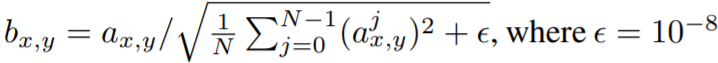

pixelwise feature vector normalization의 수식은 위와 같다. 이때 N은 feature map의 크기이며, a_x,y는 pixel(x, y)에서의 original vector이고 b_x,y는 pixel(x, y)에서의 normalized vector이다.

In [ ]:
import torch
import torch.nn as nn

class PixelNormLayer(nn.Module):
    def __init__(self):
        super(PixelNormLayer, self).__init__()

    def forward(self, x):
        return x * torch.rsqrt(torch.mean(x**2, dim=1, keepdim=True) + 1e-8)

    def __repr__(self):
        return self.__class__.__name__

pixelwise feature vector normalization의 코드는 위와 같다.

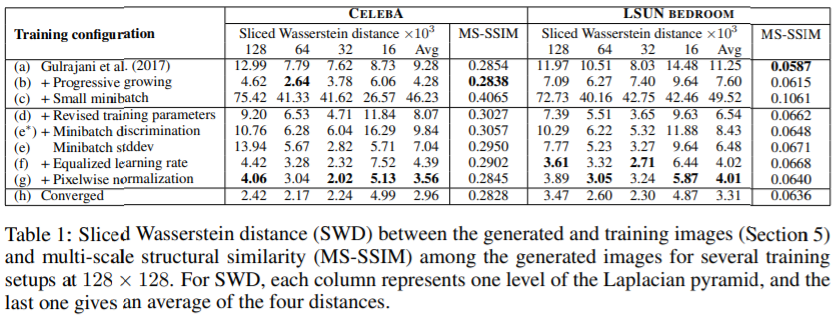

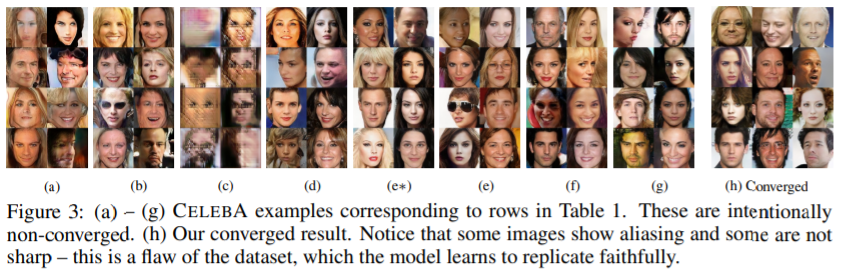

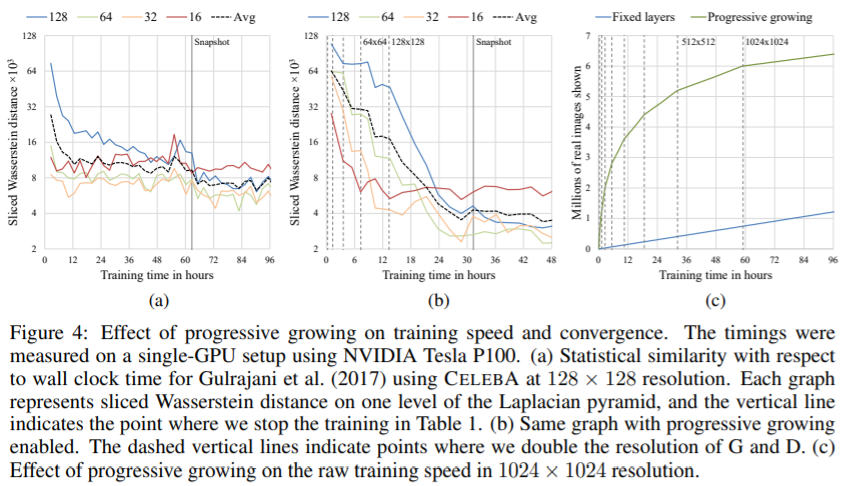

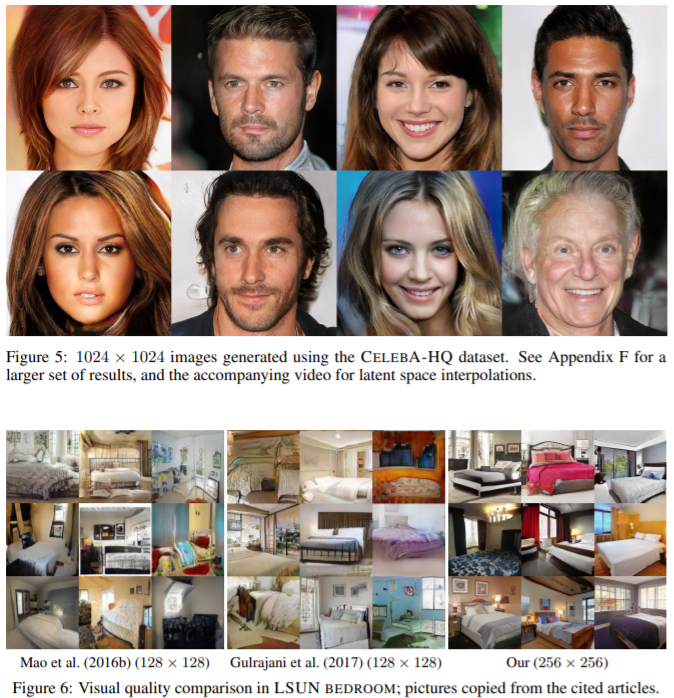

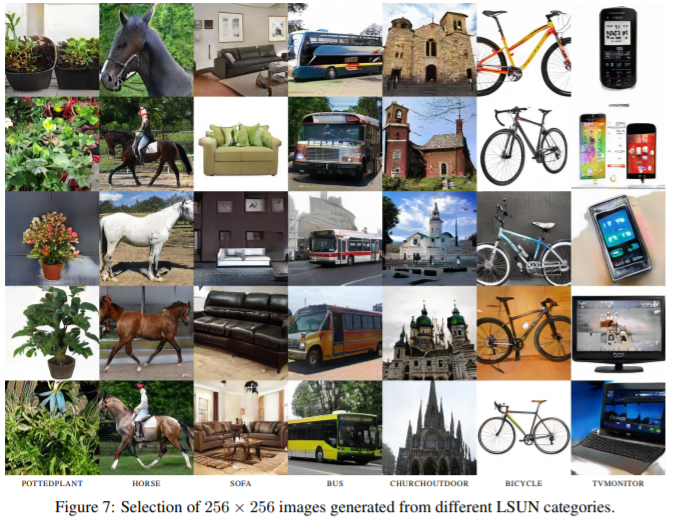